table of contents  
1. Prepare  
2. Read Dataset, and Preprocess  
3. Possesion / Non Possesion

# Prepare

## Import Library
please pull this [repo](https://github.com/saeeeeru/AutoFomationDetector)

In [1]:
import os, time, sys
from datetime import datetime, date
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab10')
%matplotlib inline

# import Metrica Utilities
sys.path.append(os.path.join('..','src'))
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel

# import AutoFormation Detector
sys.path.append(os.path.join('..','..','..','football-analysis','AutoFormationDetector','src'))
from main import AutoFormationDetector

## Setting static parameter

In [2]:
base_dir = os.path.join('..')
data_dir = os.path.join(base_dir, '..', 'sample-data', 'data')

# Read Dataset, and Preprocess

In [3]:
# Read Daset
dataset_dict = {}
for game_id in tqdm(range(1,3)):
    events_df = mio.read_event_data(data_dir, game_id)
    tracking_home_df = mio.tracking_data(data_dir, game_id, 'Home')
    tracking_away_df = mio.tracking_data(data_dir, game_id, 'Away')

    # convert positions
    events_df = mio.to_metric_coordinates(events_df)
    tracking_home_df = mio.to_metric_coordinates(tracking_home_df)
    tracking_away_df = mio.to_metric_coordinates(tracking_away_df)

    # rebase direction
    tracking_home_df, tracking_away_df, events_df = mio.to_single_playing_direction(tracking_home_df, tracking_away_df, events_df)
    if game_id == 1:
        columns = [c for c in tracking_away_df.columns if c[-1].lower() in ['x','y']]
        tracking_away_df.loc[:,columns] *= -1
    else:
        columns = [c for c in tracking_home_df.columns if c[-1].lower() in ['x','y']]
        tracking_home_df.loc[:,columns] *= -1
    dataset_dict[f'game_id={game_id}'] = [tracking_home_df, tracking_away_df, events_df]

    # calculate player Velocities
    # tracking_home_df = mvel.calc_player_velocities(tracking_home_df, smoothing=True, filter_='moving average')
    # tracking_away_df = mvel.calc_player_velocities(tracking_away_df, smoothing=True, filter_='moving average')

0%|          | 0/2 [00:00<?, ?it/s]Reading team: home
Reading team: away
 50%|█████     | 1/2 [00:01<00:01,  1.58s/it]Reading team: home
Reading team: away
100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


# Possession, Non Possession

## get possession

In [4]:
c_list = ['Period', 'Team', 'Start Time [s]', 'End Time [s]']

In [5]:
posession_list = []
for k, df_list in dataset_dict.items():
    events_df = df_list[-1]
    for period in events_df.Period.unique():
        events_df_tmp = events_df[events_df.Period==period]
        
        team, st, ed = events_df_tmp.groupby('Period').agg({'Team':'first', 'Start Time [s]':'first', 'End Time [s]':'last'}).values[0,:]
        
        flg_array = events_df_tmp.Team.values[:-1] != events_df_tmp.Team.values[1:]
        events_df_only_transition = events_df_tmp[events_df_tmp.index.isin(events_df_tmp.index.values[1:][flg_array])]

        index_last = events_df_only_transition.index.values[-1]

        for i in events_df_only_transition.index:
            team_, st_ = events_df_only_transition.loc[i, c_list[1:-1]]

            if i == index_last:
                posession = [period, team_, st_, ed]
            else:
                posession  = [period, team, st, st_]

            # append
            posession_list.append(posession)

            # update
            team, st = team_, st_

    # make df
    possession_df = pd.DataFrame(data=posession_list, columns=c_list)
    dataset_dict[k].append(possession_df)

## visualize

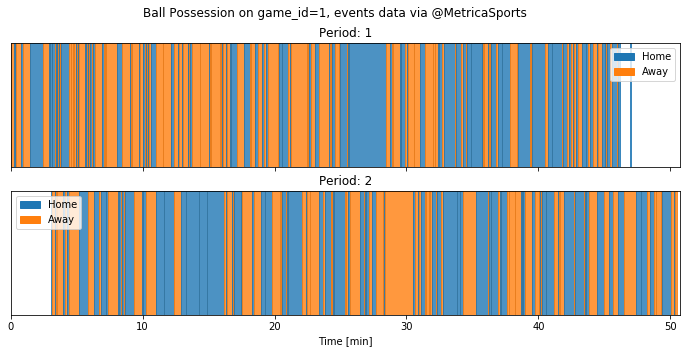

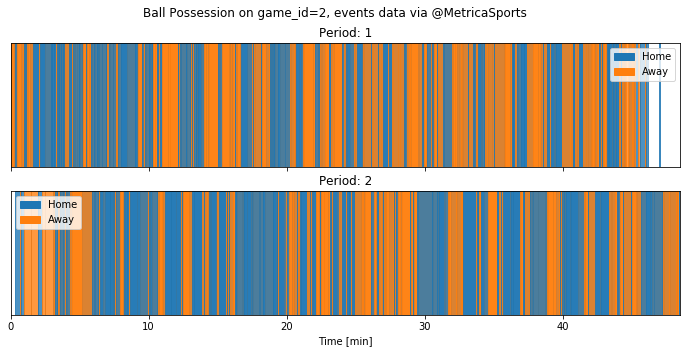

In [6]:
import matplotlib.patches as patches

color_dict = {'Home':cmap(0), 'Away': cmap(1)}

for k, df_list in dataset_dict.items():
    events_df, possession_df = df_list[-2:]

    n_period = len(events_df.Period.unique())
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 2.5*n_period), sharex=True)

    for period in events_df.Period.unique():
        ax = axes[period-1]
        possession_df_tmp = possession_df[possession_df.Period==period]
        for i in possession_df_tmp.index:
            team, st_s, ed_s = possession_df_tmp.loc[i, c_list[1:]]
            st_m, ed_m = (st_s/60., ed_s/60.) if period==1 else (st_s/60-45, ed_s/60-45)
            rect = patches.Rectangle((st_m,0), width=ed_m-st_m, height=1, color=color_dict[team], alpha=0.8)
            ax.add_patch(rect)

        ax.get_yaxis().set_visible(False)
        ax.set_xlim([0, ed_m])
        ax.set_title(f'Period: {period}')

        ax.legend(handles=[patches.Patch(color=c, label=l) for l, c in color_dict.items()])

    ax.set_xlabel('Time [min]')
    fig.suptitle(f'Ball Possession on {k}, events data via @MetricaSports')

    plt.savefig(os.path.join(base_dir, 'reports', 'figure', f'posession-{k}.png'), bbox_inches='tight')

## split tracking_df based on possession_df

In [7]:
def replace_value_to_nan(data_array, index_array):
    for i, d in enumerate(index_array.sum(axis=1)):
        if d!=2*n_player:
            data_array[i, np.nonzero(np.isnan(data_array[i+1]))] = np.nan

    return data_array

In [8]:
import itertools

data_dict = {k_:list() for k_ in itertools.chain.from_iterable([[f'{k}_Home_on', f'{k}_Home_off', f'{k}_Away_on', f'{k}_Away_off'] for k in list(dataset_dict.keys())])}

c = 'Time [s]'
n_player = 10

for k, df_list in dataset_dict.items():
    tracking_home_df, tracking_away_df, events_df, possession_df = df_list
    print(k)

    for i, (team, st, ed) in tqdm(possession_df.iloc[:,1:].iterrows()):
        tracking_home_array = tracking_home_df[(st <= tracking_home_df[c])&(tracking_home_df[c] < ed)&(tracking_home_df[c].apply(lambda x: f'{x: .2f}').str.contains('.00'))].iloc[:,4:-2].values
        index_home_array = ~np.isnan(tracking_home_array)
        if len(tracking_home_array[index_home_array]) % (n_player*2) == 0:
            tracking_home_list = tracking_home_array[index_home_array].reshape(-1,n_player*2).tolist()
        else:
            tracking_home_array = replace_value_to_nan(tracking_home_array, index_home_array)
            tracking_home_list = tracking_home_array[~np.isnan(tracking_home_array)].reshape(-1,n_player*2).tolist()

        tracking_away_array = tracking_away_df[(st <= tracking_away_df[c])&(tracking_away_df[c] < ed)&(tracking_away_df[c].apply(lambda x: f'{x: .2f}').str.contains('.00'))].iloc[:,4:-2].values
        index_away_array = ~np.isnan(tracking_away_array)
        if len(tracking_away_array[index_away_array]) % (n_player*2) == 0:
            tracking_away_list = tracking_away_array[index_away_array].reshape(-1,n_player*2).tolist()
        else:
            tracking_away_array = replace_value_to_nan(tracking_away_array, index_away_array)
            tracking_away_list = tracking_away_array[~np.isnan(tracking_away_array)].reshape(-1,n_player*2).tolist()


        if team == 'Home': 
            data_dict[f'{k}_Home_on'] += tracking_home_list
            data_dict[f'{k}_Away_off'] += tracking_away_list
        else:
            data_dict[f'{k}_Away_on'] += tracking_away_list
            data_dict[f'{k}_Home_off'] += tracking_home_list

0it [00:00, ?it/s]game_id=1
474it [03:10,  2.48it/s]
0it [00:00, ?it/s]game_id=2
976it [06:17,  2.59it/s]


In [9]:
from scipy.stats import zscore
for k, data_list in data_dict.items():
        data_dict[k] = np.array([zscore(data) for data in np.array(data_list).reshape(-1,n_player,2)])

In [12]:
params_dict = {
    'fig_dir':os.path.join(base_dir,'reports','figure','AutoFormationDetector'),
    'modeldir':os.path.join(base_dir,'models','AutoFormationDetector'),
    'load' : True,
    'n_clusters':4,
    'mesh_size':.01,
    'n_iterations':10,
}
auto_formation_detector = AutoFormationDetector(params_dict, data_dict)

In [13]:
auto_formation_detector.run()

loading role distribution ...
Running Agglomerative Clustering of role_distribution
game_id=1_Away_off = 0
game_id=1_Home_off = 3
game_id=2_Away_off = 1
game_id=1_Home_on = 2
game_id=2_Away_on = 1
game_id=2_Home_on = 0
game_id=2_Home_off = 0
game_id=1_Away_on = 0
Plotting Clustering Results
